In [2]:
#Setup

from mlwpy import *
%matplotlib inline

diabetes = datasets.load_diabetes()
tts = skms.train_test_split(diabetes.data,
                           diabetes.target,
                           test_size=.25,
                           random_state=42)

(diabetes_train_ftrs, diabetes_test_ftrs,
diabetes_train_tgt, diabetes_test_tgt) = tts

### 7.1 Baseline Regressors

In [3]:
baseline = dummy.DummyRegressor(strategy='median')

In [4]:
strategies = ['constant', 'quantile', 'mean', 'median']
baseline_args = [{"strategy":s} for s in strategies]

#additional args for constant and quantile
baseline_args[0]['constant'] = 50.0
baseline_args[1]['quantile'] = 0.75

#similar to ch 5 but using a list comprehension
#process a single argument package (a dict)

def do_one(**args):
    baseline = dummy.DummyRegressor(**args)
    baseline.fit(diabetes_train_ftrs, diabetes_train_tgt)
    base_preds = baseline.predict(diabetes_test_ftrs)
    return metrics.mean_squared_error(base_preds, diabetes_test_tgt)

#gather all results via a list comprehension
mses = [do_one(**bla) for bla in baseline_args]

display(pd.DataFrame({'mse':mses}, index=strategies))

,mse
constant,"14,657.6847"
quantile,"10,216.3874"
mean,"5,607.1979"
median,"5,542.2252"


### 7.2 Additional Measures for Regression

In [5]:
def rms_error(actual, predicted):
    ' root-mean-squared-error function '
    #lesser values are better - closer to 0
    mse = metrics.mean_squared_error(actual, predicted)
    return np.sqrt(mse)

def neg_rmse_score(actual, predicted):
    ' rmse based score function '
    #greater values are better
    return -rms_error(actual, predicted)


def neg_rmse_scorer(mod, ftrs, tgt_actual):
    ' rmse scorer suitable for scoring arg '
    tgt_pred = mod.predict(ftrs)
    return neg_rmse_score(tgt_actual, tgt_pred)
    

knn = neighbors.KNeighborsRegressor(n_neighbors=3)
skms.cross_val_score(knn,
                    diabetes.data, diabetes.target,
                    cv=skms.KFold(5, shuffle=True),
                    scoring=neg_rmse_scorer)


array([-58.0034, -64.9886, -63.1431, -61.8124, -57.6243])

In [6]:
lr = linear_model.LinearRegression()

print(lr.score.__doc__.splitlines()[0])

Return the coefficient of determination :math:`R^2` of the


In [7]:
help(lr.score)

Help on method score in module sklearn.base:

score(X, y, sample_weight=None) method of sklearn.linear_model._base.LinearRegression instance
    Return the coefficient of determination :math:`R^2` of the
    prediction.
    
    The coefficient :math:`R^2` is defined as :math:`(1 - \frac{u}{v})`,
    where :math:`u` is the residual sum of squares ``((y_true - y_pred)
    ** 2).sum()`` and :math:`v` is the total sum of squares ``((y_true -
    y_true.mean()) ** 2).sum()``. The best possible score is 1.0 and it
    can be negative (because the model can be arbitrarily worse). A
    constant model that always predicts the expected value of `y`,
    disregarding the input features, would get a :math:`R^2` score of
    0.0.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Test samples. For some estimators this may be a precomputed
        kernel matrix or a list of generic objects instead with shape
        ``(n_samples, n_samples_fitted)``, whe

In [8]:
#sse - sum of squared errors

our_preds = np.array([1, 2, 3])
mean_preds = np.array([2, 2, 2])
actual = np.array([2, 3, 4])

sse_ours = np.sum((our_preds - actual)**2)
sse_mean = np.sum((mean_preds - actual)**2)

# r-squared formula
r_2 = 1 - (sse_ours / sse_mean)
print("manual r2:{:5.2f}".format(r_2))

manual r2: 0.40


In [9]:
print(sse_ours)
print(sse_mean)

3
5


In [10]:
baseline = dummy.DummyRegressor(strategy='mean')

baseline.fit(diabetes_train_ftrs, diabetes_train_tgt)
base_preds = baseline.predict(diabetes_test_ftrs)

#r2 is not symmetric because true values have priority
#and are used to compute target mean
base_r2_sklearn = metrics.r2_score(diabetes_test_tgt, base_preds)
print(base_r2_sklearn)

-0.014016723490579253


In [11]:
#sklearn-train-mean to predict test tgts
base_errors = base_preds - diabetes_test_tgt
sse_base_preds = np.dot(base_errors, base_errors)

#train-mean to predict test targets
train_mean_errors = np.mean(diabetes_train_tgt) - diabetes_test_tgt
sse_mean_train = np.dot(train_mean_errors, train_mean_errors)

#test-mean to predict test targets
test_mean_errors = np.mean(diabetes_test_tgt) - diabetes_test_tgt
sse_mean_test = np.dot(test_mean_errors, test_mean_errors)

print("sklearn train-mean model SSE(on test):", sse_base_preds)
print(" manual train-mean model SSE(on test):", sse_mean_train)
print("  manual test-mean model SSE(on test):", sse_mean_test)

sklearn train-mean model SSE(on test): 622398.9703179051
 manual train-mean model SSE(on test): 622398.9703179051
  manual test-mean model SSE(on test): 613795.5675675676


In [12]:
1 - (sse_base_preds / sse_mean_test)

-0.014016723490578809

In [13]:
print(base_r2_sklearn)
print(1 - (sse_base_preds / sse_mean_test))

-0.014016723490579253
-0.014016723490578809


### 7.3 Residual Plots

In [14]:
#Error Plots
ape_df = pd.DataFrame({'predicted' : [4, 2, 9],
                       'actual'    : [3, 5, 7]})

ape_df['error'] = ape_df['predicted'] - ape_df['actual']

ape_df.index.name = 'example'
display(ape_df)

,predicted,actual,error
example,,,
0,4,3,1
1,2,5,-3
2,9,7,2


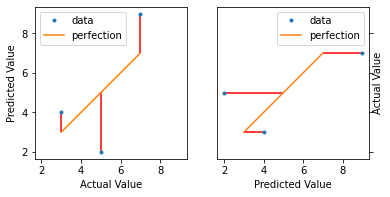

In [15]:
def regression_errors(figsize, predicted, actual, errors='all'):
    ''' figsize -> subplots;
        predicted/actual data -> columns in a DataFrame
        errors -> "all" or sequence of indices '''
    
    fig, axes = plt.subplots(1, 2, figsize=figsize,
                             sharex=True, sharey=True)
    df = pd.DataFrame({'actual':actual,
                       'predicted':predicted})
    
    for ax, (x,y) in zip(axes, it.permutations(['actual',
                                                'predicted'])):
        # plot the data as '.'; perfect as y=x line
        ax.plot(df[x], df[y], '.', label='data')
        ax.plot(df['actual'], df['actual'], '-',
                label='perfection')
        ax.legend()
        
        ax.set_xlabel('{} Value'.format(x.capitalize()))
        ax.set_ylabel('{} Value'.format(y.capitalize()))
        ax.set_aspect('equal')
        
    axes[1].yaxis.tick_right()
    axes[1].yaxis.set_label_position("right")
    
    #show connecting bars from data to perfect
    #for all or only those specified?
    if errors == 'all':
        errors = range(len(df))
    if errors:
        acts = df.actual.iloc[errors]
        preds = df.predicted.iloc[errors]
        axes[0].vlines(acts, preds, acts, 'r')
        axes[1].hlines(acts, preds, acts, 'r')
        
regression_errors((6, 3), ape_df.predicted, ape_df.actual)

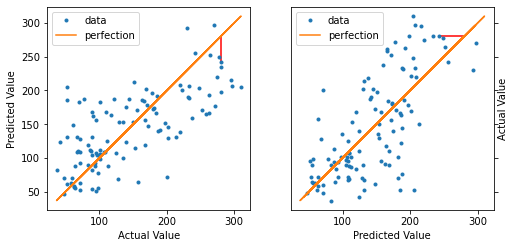

In [16]:
lr = linear_model.LinearRegression()
preds = (lr.fit(diabetes_train_ftrs, diabetes_train_tgt)
           .predict(diabetes_test_ftrs))

regression_errors((8, 4), preds, diabetes_test_tgt, errors=[-20])

In [17]:
#Residual Plots - difference between actuals and predicted

ape_df = pd.DataFrame({'predicted' : [4, 2, 9],
                       'actual'    : [3, 5, 7]})

ape_df['error'] = ape_df['predicted'] - ape_df['actual']
ape_df['resid'] = ape_df['actual'] - ape_df['predicted']

ape_df.index.name = 'example'
display(ape_df)

,predicted,actual,error,resid
example,,,,
0,4,3,1,-1
1,2,5,-3,3
2,9,7,2,-2


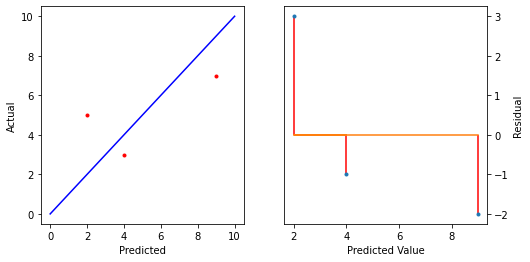

In [18]:
def regression_residuals(ax, predicted, actual,
                         show_errors=None, right=False):
    ''' figsize -> subplots;
        predicted/actual data -> columns of a DataFrame
        errors -> "all" or sequence of indices '''
    df = pd.DataFrame({'actual': actual,
                       'predicted': predicted})
    df['error'] = df.actual - df.predicted
    ax.plot(df.predicted, df.error, '.')
    ax.plot(df.predicted, np.zeros_like(predicted), '-')
    
    if right:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        ax.set_xlabel('Predicted Value')
        ax.set_ylabel('Residual')
        
    if show_errors == 'all':
        show_errors = range(len(df))
    if show_errors:
        preds = df.predicted.iloc[show_errors]
        errors = df.error.iloc[show_errors]
        ax.vlines(preds, 0, errors, 'r')
        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.plot(ape_df.predicted, ape_df.actual, 'r.', #pred vs actual
         [0, 10], [0, 10], 'b-')                #perfect line
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
regression_residuals(ax2, ape_df.predicted, ape_df.actual,
                     'all', right=True)

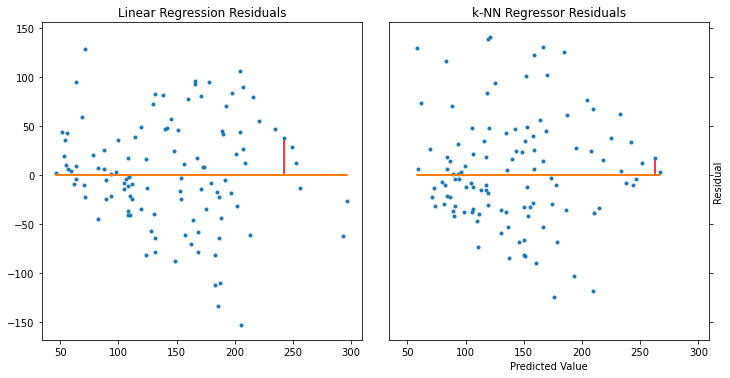

In [19]:
lr = linear_model.LinearRegression()
knn = neighbors.KNeighborsRegressor()

models = [lr, knn]

fig, axes = plt.subplots(1, 2, figsize=(10, 5),
                         sharex=True, sharey=True)
fig.tight_layout()

for model, ax, on_right in zip(models, axes, [False, True]):
    preds = (model.fit(diabetes_train_ftrs, diabetes_train_tgt)
                  .predict(diabetes_test_ftrs))
    
    regression_residuals(ax, preds, diabetes_test_tgt, [-20], on_right)
    
axes[0].set_title('Linear Regression Residuals')
axes[1].set_title('k-NN Regressor Residuals');

In [20]:
print(diabetes_test_tgt[-20])

280.0


,x,std-ized
mean,2.5000,0.0000
std,4.6706,1.0000


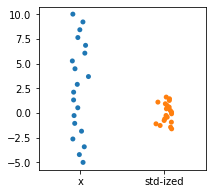

In [21]:
#1D standardization
#place evenly spaced values in a dataframe

xs = np.linspace(-5, 10, 20)
df = pd.DataFrame(xs, columns=['x'])

#center ( - mean) and scale (/ std)
df['std-ized'] = (df.x - df.x.mean()) / df.x.std()

#show original and new data; compute statistics
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

sns.stripplot(data=df)
display(df.describe().loc[['mean', 'std']])

In [22]:
# 2 1D standardizations
xs = np.linspace(-5, 10, 20)
ys = 3*xs + 2 + np.random.uniform(20, 40, 20)

df = pd.DataFrame({'x':xs, 'y':ys})
df_std_ized = (df - df.mean()) / df.std()

display(df_std_ized.describe().loc[['mean', 'std']])

,x,y
mean,0.0000,-0.0000
std,1.0000,1.0000


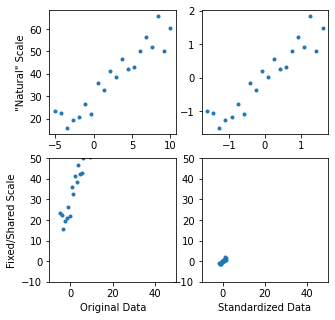

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(5,5))

ax[0,0].plot(df.x, df.y, '.')
ax[0,1].plot(df_std_ized.x, df_std_ized.y, '.')
ax[0,0].set_ylabel('"Natural" Scale')

ax[1,0].plot(df.x, df.y, '.')
ax[1,1].plot(df_std_ized.x, df_std_ized.y, '.')

ax[1,0].axis([-10, 50, -10, 50])
ax[1,1].axis([-10, 50, -10, 50])

ax[1,0].set_ylabel('Fixed/Shared Scale')
ax[1,0].set_xlabel('Original Data')
ax[1,1].set_xlabel('Standardized Data');

In [23]:
train_xs, test_xs = skms.train_test_split(xs.reshape(-1,1), test_size=.5)

scaler = skpre.StandardScaler()
scaler.fit(train_xs).transform(test_xs)

array([[ 0.5726],
       [ 0.9197],
       [ 1.9608],
       [ 0.7462],
       [ 1.7873],
       [-0.295 ],
       [ 1.6138],
       [ 1.4403],
       [-0.1215],
       [ 1.0932]])

In [24]:
# standarize and fit model using a pipeline
(train_xs, test_xs,
train_ys, test_ys) = skms.train_test_split(xs.reshape(-1,1),
                                           ys.reshape(-1, 1),
                                           test_size=.5)

scaler = skpre.StandardScaler()
lr = linear_model.LinearRegression()

std_lr_pipe = pipeline.make_pipeline(scaler, lr)

std_lr_pipe.fit(train_xs, train_ys).predict(test_xs)

array([[17.0989],
       [29.4954],
       [41.8919],
       [36.9333],
       [61.7263],
       [24.5368],
       [31.9747],
       [49.3298],
       [51.8091],
       [59.247 ]])